In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [3]:
symbols = ['PKO.WA', 'MBK.WA']

In [4]:
pkombk = yf.download(symbols, start='2014-01-10', end='2025-11-29')['Close']
print(pkombk.head())

C:\Users\matka\AppData\Local\Temp\ipykernel_27312\2261129459.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pkombk = yf.download(symbols, start='2014-01-10', end='2025-11-29')['Close']
[*********************100%***********************]  2 of 2 completed

Ticker          MBK.WA     PKO.WA
Date                             
2014-01-10  441.432617  27.788744
2014-01-13  450.676056  28.035372
2014-01-14  463.230621  28.760736
2014-01-15  462.632782  29.594908
2014-01-16  462.172882  29.573143


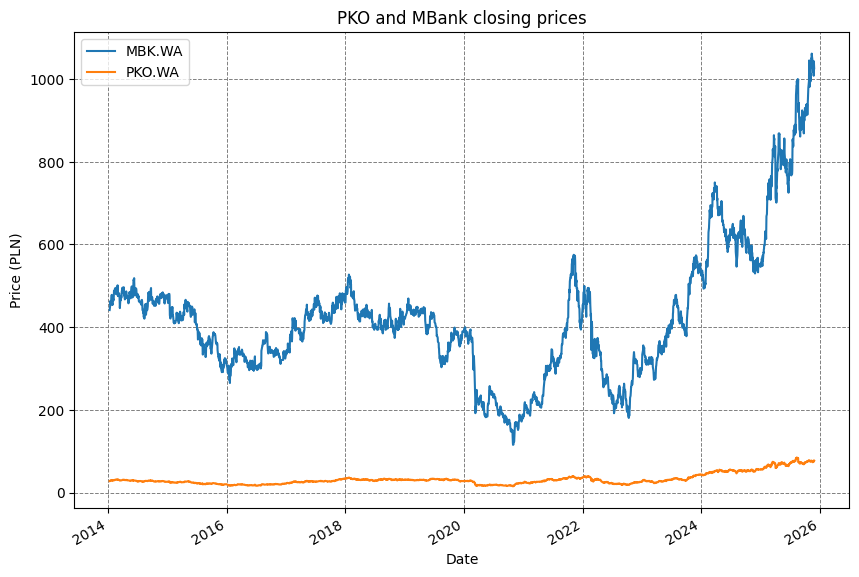

In [5]:
pkombk.plot(figsize=(10,7))
plt.legend()
plt.title('PKO and MBank closing prices')
plt.xlabel('Date')
plt.ylabel('Price (PLN)')
plt.grid(which = 'major', linestyle='--', color='gray', linewidth=0.7)

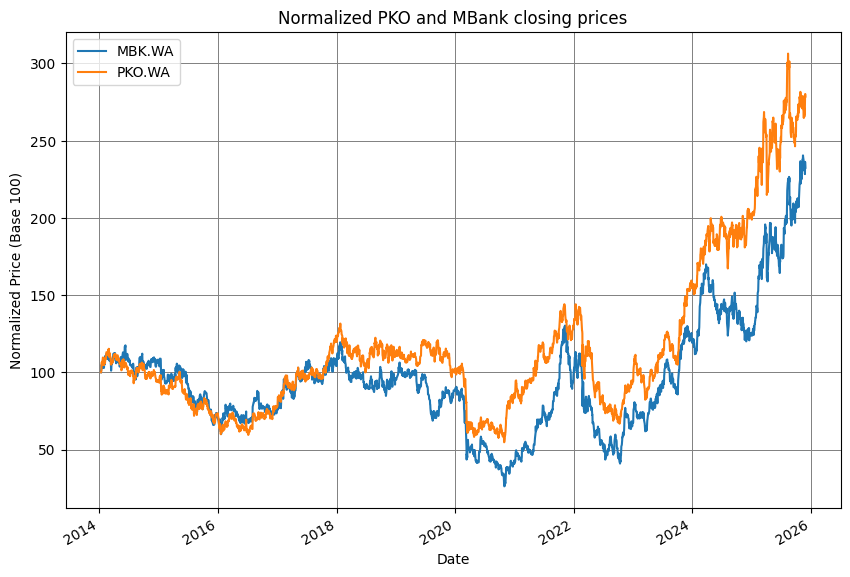

In [6]:
#I see that stocks differ in price too much to directly compare them. I need to normalize them first.
pkombk_normalized = (pkombk/pkombk.iloc[0]) * 100

#Now I can plot normalized prices
pkombk_normalized.plot(figsize=(10,7))
plt.legend()
plt.title('Normalized PKO and MBank closing prices')
plt.xlabel('Date')
plt.ylabel('Normalized Price (Base 100)')
plt.grid(which = 'major', linestyle='-', color='gray', linewidth=0.7)

In [7]:
#As expected, becasue both are large banks operating in the same market
#their stock prices move in a similar way over time.
#This suggests a potential for statistical arbitrage strategies.

price_pko = pkombk['PKO.WA']
price_mbk = pkombk['MBK.WA']

#Calculating logarithmic prices
x = np.log(price_pko)
y = np.log(price_mbk)

#Calculating logarithmic returns
pko_log_returns = x - x.shift(1)
mbk_log_returns = y - y.shift(1)

#combining returns into a single DataFrame and removing NaN values
log_returns = pd.DataFrame({'PKO_Log_Returns': pko_log_returns, 'MBK_Log_Returns': mbk_log_returns})
log_returns = log_returns.dropna()

print(log_returns.head())

            PKO_Log_Returns  MBK_Log_Returns
Date                                        
2014-01-13         0.008836         0.020723
2014-01-14         0.025544         0.027476
2014-01-15         0.028591        -0.001291
2014-01-16        -0.000736        -0.000995
2014-01-17        -0.015075        -0.014836


In [8]:
#Creating correlation matrix
df = log_returns
R = df.values
T, N = R.shape

#Calculating the correlation matrix

# Mean centering the returns
means = np.mean(R, axis=0)
X = R - means

#Covariance matrix
Cov = (X.T @ X) / (T - 1)

#Standard deviations
sigma = np.sqrt(np.diag(Cov))

#Correlation matrix
denominators = np.outer(sigma, sigma)
Corr = Cov / denominators


#Presenting findings
print("1. DAILY VOLATILITY (standard deviation of log returns):")
print(pd.Series(sigma, index=df.columns))

print("\n" + "-" * 50)
print("ANNUALIZED VOLATILITY (Risk per year):")
annualized_vol = sigma * np.sqrt(252)  # Assuming 252 trading days in a year
print(pd.Series(annualized_vol, index=df.columns).apply(lambda x: f"{x:.2%}"))\

print("\n" + "-" * 50)
print("COVARIANCE MATRIX:")
#Scientific notation for better readability
print(pd.DataFrame(Cov, index=df.columns, columns=df.columns))

print("\n" + "-" * 50)
print("CORRELATION MATRIX:")
print(pd.DataFrame(Corr, index=df.columns, columns=df.columns))

1. DAILY VOLATILITY (standard deviation of log returns):
PKO_Log_Returns    0.019932
MBK_Log_Returns    0.024743
dtype: float64

--------------------------------------------------
ANNUALIZED VOLATILITY (Risk per year):
PKO_Log_Returns    31.64%
MBK_Log_Returns    39.28%
dtype: object

--------------------------------------------------
COVARIANCE MATRIX:
                 PKO_Log_Returns  MBK_Log_Returns
PKO_Log_Returns         0.000397         0.000309
MBK_Log_Returns         0.000309         0.000612

--------------------------------------------------
CORRELATION MATRIX:
                 PKO_Log_Returns  MBK_Log_Returns
PKO_Log_Returns         1.000000         0.625849
MBK_Log_Returns         0.625849         1.000000


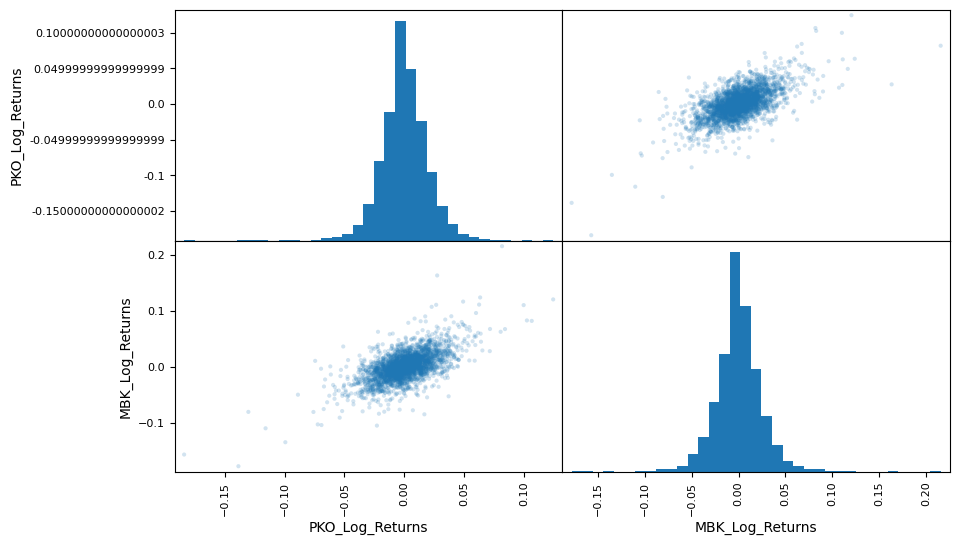

In [9]:
#Visualizing relationships with pandas scatter matrix

pd.plotting.scatter_matrix(log_returns,
 alpha=0.2,
 diagonal='hist',
 hist_kwds={'bins': 35},
 figsize=(10, 6));




In [10]:
#Having corellaction matrix, I can now move on to cointegeation tests

#Lets recall logarithmic prices
x = np.log(price_pko)
y = np.log(price_mbk)

#Step 1: Regress y on x to find the hedge ratio
reg = np.polyfit(x, y, 1)
beta = reg[0]
alpha = reg[1]

print(f"Hedge Ratio (Beta): {beta}")

Hedge Ratio (Beta): 0.8681675575802923


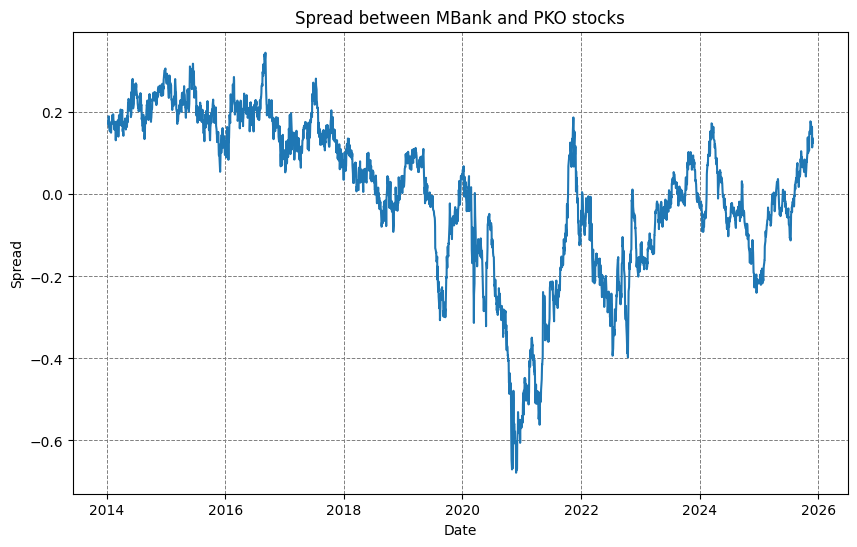

In [11]:
#Calculating and plotting the spread 

spread = y - alpha - beta * x 

plt.figure(figsize=(10,6))
plt.plot(spread)
plt.title('Spread between MBank and PKO stocks')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.grid(which = 'major', linestyle='--', color='gray', linewidth=0.7)

In [12]:
y_values = spread.dropna().values
dy = np.diff(y_values)
y_lag = y_values[:-1]

X = y_lag.reshape(-1, 1)
Y = dy.reshape(-1, 1)

#Calculatting gamma - the speed of reversion to the mean
XtX = X.T @ X
XtY = X.T @ Y
gamma = (np.linalg.inv(XtX) @ XtY)[0][0]

print(f"Speed of Reversion to the Mean (Gamma): {gamma}")

#Calculating T-statistic for gamma

#expected value of gamma
dy_pred = X * gamma

#residuals
residuals = Y - dy_pred

#variance of residuals
n = len(Y)
sigma_sq = np.sum(residuals**2) / (n - 1)

#standard error of gamma
se_gamma = np.sqrt(sigma_sq / XtX[0][0])

#T-statistic
t_stat = gamma / se_gamma

print(f"T-statistic for Gamma: {t_stat}")

#Interpreting results

print("\nInterpretation:")
if t_stat < -2.89:
    print("Spread is stationary (mean-reverting). Suitable for statistical arbitrage strategies.")
elif t_stat < -1.95:
    print("Spread is borderline stationary. Caution advised for statistical arbitrage strategies.")
else:
    print("Spread is non-stationary. Not suitable for statistical arbitrage strategies.")


    

Speed of Reversion to the Mean (Gamma): -0.005110245562730542
T-statistic for Gamma: -2.8031943098365

Interpretation:
Spread is borderline stationary. Caution advised for statistical arbitrage strategies.



Running Kalman Filter for 3033 time steps


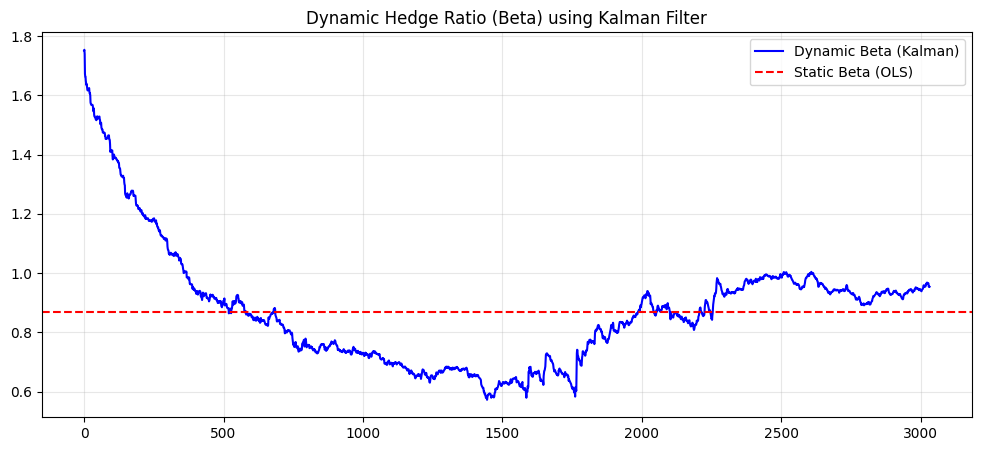

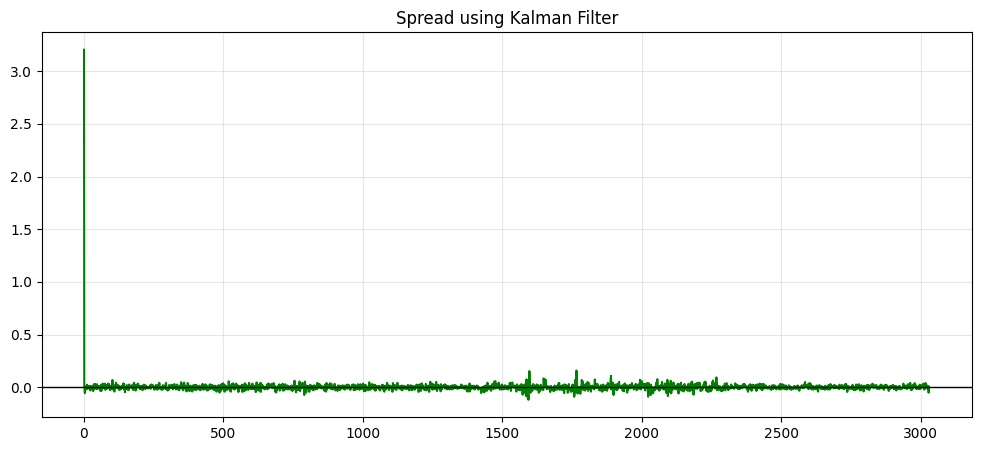

In [13]:
#OLS regression showed that spread is borderline stationary
#I will now check how Kalman filter performs

#Data preparation
y_obs = y.values
x_obs = x.values
T = len(y_obs)

#Kalman filter implementation

#Tunable parameters
delta = 1e-4
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.expand_dims(np.vstack([[x_obs], [np.ones(T)]]).T, axis=1)

state_mean = np.zeros(2)
state_mean[0] = 0.8681  # Initial beta from OLS
state_mean[1] = 0 

#Estimation error
state_cov = np.eye(2)

#Storage for results
beta_dyn =[]
alpha_dyn = []
y_pred = []
error_e = []
q_history = []

#Loop

print(f"\nRunning Kalman Filter for {T} time steps")

for t in range(T):
    #Prediction step
    #We predict that the state today is the same as yesterday
    state_mean_pri = state_mean
    state_cov_pri = state_cov + trans_cov

    #Observation
    H = np.array([[x_obs[t], 1]])

    #Prediction error
    y_hat = H @ state_mean_pri
    error = y_obs[t] - y_hat


    #Variance of prediction error
    R = 1e-3
    S = H @ state_cov_pri @ H.T + R

    #Kalman Gain
    K = state_cov_pri @ H.T @ np.linalg.inv(S)

    #Update step
    state_mean = state_mean_pri + K @ error
    
    #Update covariance
    state_cov = (np.eye(2) - K @ H) @ state_cov_pri

    #Storing results
    beta_dyn.append(state_mean[0])
    alpha_dyn.append(state_mean[1])
    y_pred.append(y_hat)
    error_e.append(error)
    q_history.append(S)

#Converting results to numpy arrays for easier handling
beta_dyn = np.array(beta_dyn).flatten()
alpha_dyn = np.array(alpha_dyn).flatten()
spread_kalman = np.array(error_e).flatten()
obs_variance = np.array(q_history).flatten()


#Plotting dynamic hedge ratio
#Plot 1: Dynamic Beta
plt.figure(figsize=(12, 5))
plt.plot(beta_dyn, label='Dynamic Beta (Kalman)', color='blue')
plt.axhline(0.868, color='red', linestyle='--', label='Static Beta (OLS)')
plt.title('Dynamic Hedge Ratio (Beta) using Kalman Filter')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: The Spread
plt.figure(figsize=(12, 5))
plt.plot(spread_kalman, label='Kalman Spread (Prediction Error)', color='green')
plt.axhline(0, color='black', linewidth=1)
plt.title('Spread using Kalman Filter')
plt.grid(True, alpha=0.3)
plt.show()

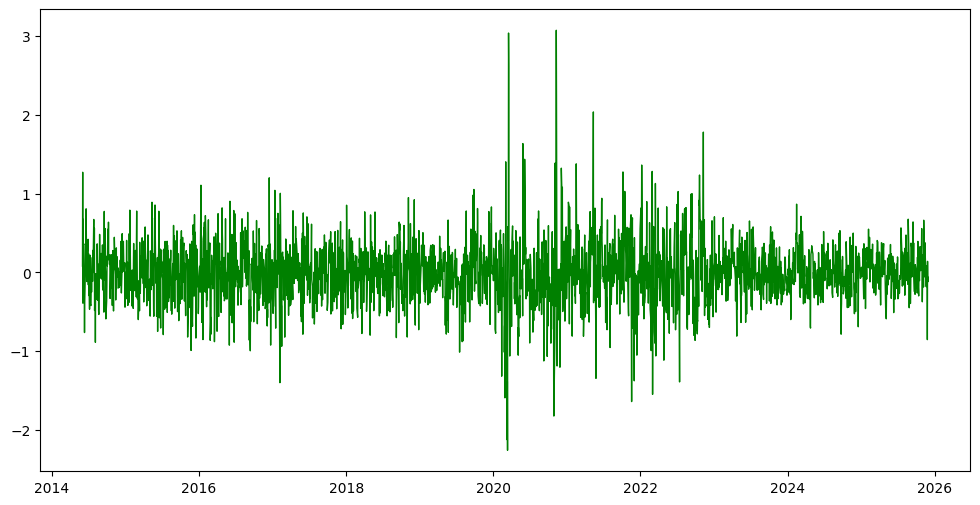

In [18]:
#Spread has big line so im going to fix it by removing burn-in period
burn_in = 100

spread_clean = spread_kalman[burn_in:]
obs_var_clean = obs_variance[burn_in:]
dates_clean = df.index[burn_in:]

z_score = spread_clean / np.sqrt(obs_var_clean)

#Fixing length mismatch
len_dates = len(df.index[burn_in:])
len_score = len(z_score)

min_len = min(len_dates, len_score)
final_dates = df.index[burn_in:][-min_len:]
final_z_score = z_score[-min_len:]


#Plot
plt.figure(figsize=(12, 6))
plt.plot(final_dates, final_z_score, label='Kalman Z-Score', color='green', linewidth=1)


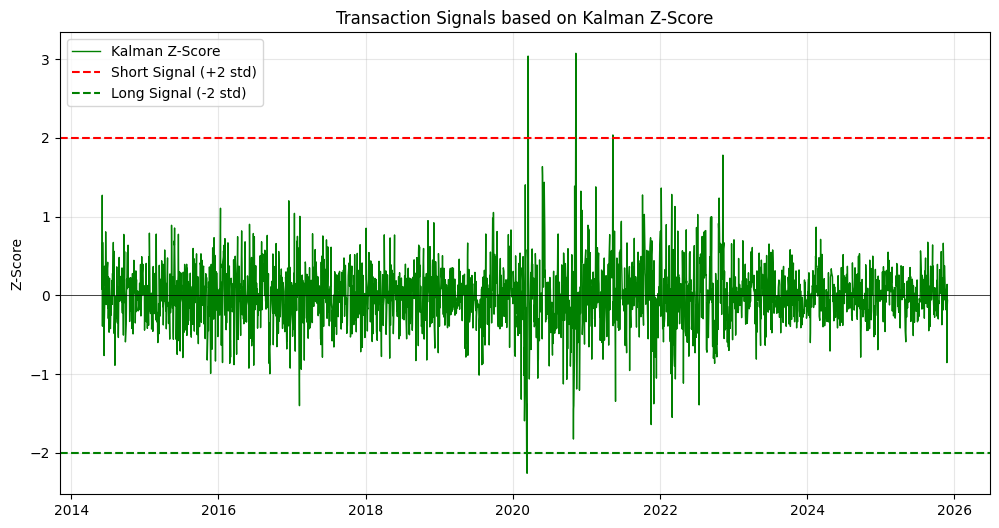

In [20]:
#Now im going to plot threshold lines which indicate potential trading signals

plt.figure(figsize=(12, 6))
plt.plot(final_dates, final_z_score, label='Kalman Z-Score', color='green', linewidth=1)

plt.axhline(2.0, color='red', linestyle='--', label='Short Signal (+2 std)')
plt.axhline(-2.0, color='green', linestyle='--', label='Long Signal (-2 std)')
plt.axhline(0, color='black', linewidth=0.5)

plt.title("Transaction Signals based on Kalman Z-Score")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylabel('Z-Score')
plt.show()